# Exercise 6
## 3 Denoising of a CT image
In the cells below there is an adapted code of the matrix construction mathod from the previous exercise.

In [2]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse import linalg
from scipy.ndimage.filters import gaussian_filter

In [22]:
def get_coords(M, Np):
    '''
    A function that computes the coordinates for each pixel. The origin is in the center of the image.
    A pixel distance of 1 is assumed.
    
    input:   
        M         An integer, number of pixels in each dimension
        Np        An integer, number of sensor pixels
    output:
        A numpy array of shape (2, M*M), contains coordinates of each pixel
    '''
    y, x = np.mgrid[0:M,0:M]
    x = x.flatten() - (M-1)/2 
    y = -1*(y.flatten() - (M-1)/2)
    
    return np.array([x, y])

In [23]:
def get_ns(alphas):
    '''
    Creates an array of vectors that lies in the straight line defined by the detector.
    These are perpendicular to the corresponding normal vectors.
    
    input:
        alphas    An array containing the rotation angles of the detector
        
    output:
        A numpy array of shape (2, len(alphas)) containing vectors in the straight lines
        defined by the detector.
    '''
    
    return np.array([np.cos(alphas), np.sin(alphas)])    

In [24]:
def construct_X(M, alphas, Np=None, tau=0):
    #create a value for Np if no value is given
    if (Np == None): Np = int(np.sqrt(2) * M) + 1
        
    alphas = np.pi/180 * np.array(alphas)
    N = Np * len(alphas)
    D = M*M
    
    #compute the pixel coordinates
    C = get_coords(M, Np)
    
    #compute the vectors to project on
    ns = get_ns(alphas)
    
    #do the projection
    p = np.dot(ns.transpose(), C) + (Np-1)/2
    
    #compute j indices
    j_indices1 = np.floor(p)
    j_indices2 = j_indices1+1
    j_indices = np.concatenate((j_indices1, j_indices2), axis=0)
    shift_mask = np.concatenate((np.arange(len(alphas)), (np.arange(len(alphas))))) * Np
    j_shift = np.ones(np.shape(j_indices))*np.array([shift_mask]).transpose() 
    
    #compute i indices
    i_indices = np.ones(np.shape(j_indices)) * np.arange(M*M)
    
    #compute weights
    weights1 = j_indices1 - p + 1
    weights2 = p - j_indices1
    weights = np.concatenate((weights1, weights2), axis=0)
    
    #filter entries with invalid indices
    filter_cond = np.logical_and(j_indices>-1,j_indices<Np)
    weights = weights[filter_cond]
    i_indices = np.array(i_indices[filter_cond], dtype=int)
    j_indices = np.array(j_indices[filter_cond] + j_shift[filter_cond], dtype=int)
    
    #filter entries where weights is zero
    filter_cond = (weights > 1e-14)
    i_indices = i_indices[filter_cond]
    j_indices = j_indices[filter_cond]
    weights = weights[filter_cond]
    
    X = sparse.coo_matrix((weights, (j_indices, i_indices)), shape=(N,D), dtype=np.float32)
    
    if (tau > 0):
        M = sparse.diags(np.ones(D)*np.sqrt(tau), 0)
        X = sparse.vstack([X,M])
    
    return X

Now we check if our adjustment works properly by running the function and plotting it an an image.

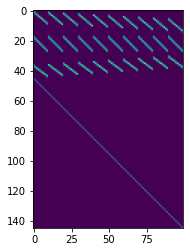

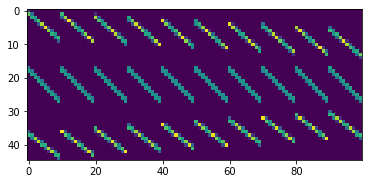

In [29]:
X = construct_X(10, [-33, 1, 42], tau=1)
X = X.todense()
plt.figure()
plt.imshow(X)

X = construct_X(10, [-33, 1, 42])
X = X.todense()
plt.figure()
plt.imshow(X)

We can see that everything works fine: if tau > 0, a matrix of shape DxD is appended vertically.

## 5 Minimizing the radiation dose

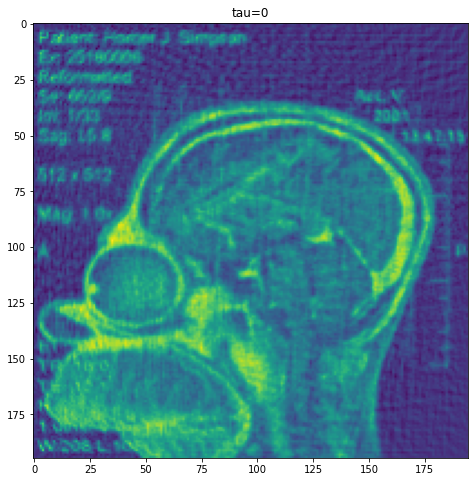

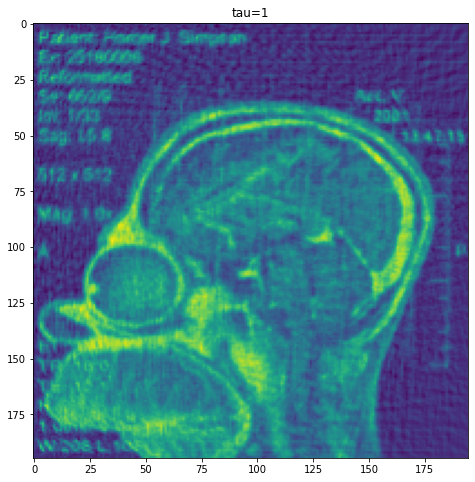

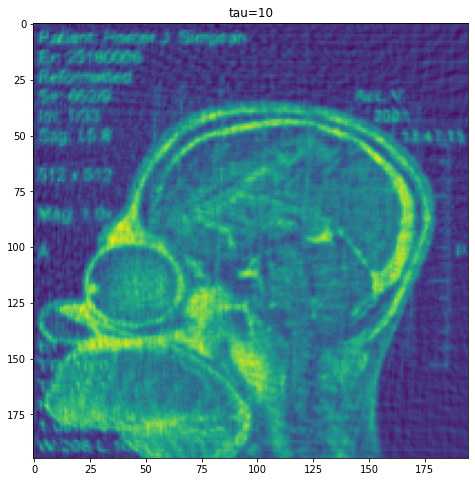

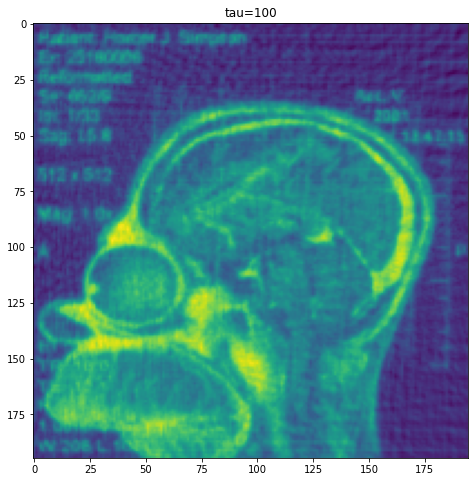

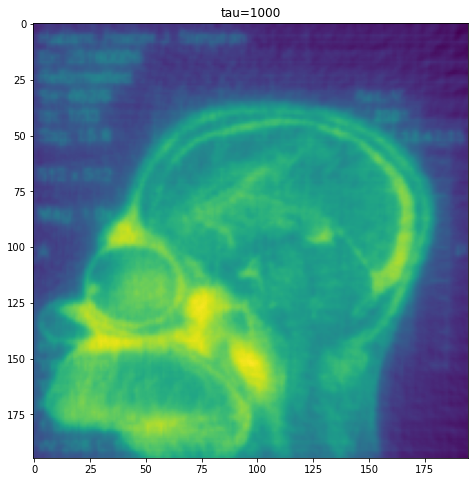

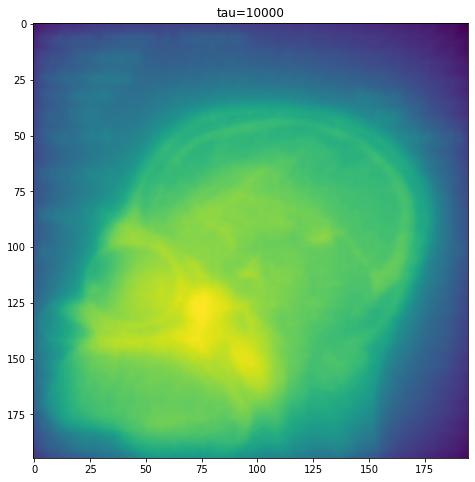

In [95]:
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")
M=195
Np=275

#select 64 projections
idx = np.linspace(0, 179, num=64, endpoint=False, dtype=int)
alphas = alphas[idx] 

pixel_idx = np.repeat([np.ones(Np)], 64, axis=0) * np.array([idx]).transpose() * Np
pixel_idx = pixel_idx.flatten() + np.repeat([np.arange(Np)], 64, axis=0).flatten()
pixel_idx = np.array(pixel_idx, dtype=int)
y = y[pixel_idx]


#compute the image for tau=0
X = construct_X(M, alphas, Np)
beta = sparse.linalg.lsqr(X, y, atol=1e-5, btol=1e-5)[0]
beta = np.reshape(beta, (M,M))
plt.figure(0, figsize=(8,8))
plt.title("tau="+str(0))
plt.imshow(beta)

y = np.append(y, np.zeros(M*M)) #append D=M*M zeros to y
tau = [1, 10, 100, 1000, 10000]
for t in tau:
    #compute and plot the image
    X = construct_X(M, alphas, Np, tau=t)
    beta = sparse.linalg.lsqr(X, y, atol=1e-5, btol=1e-5)[0]
    beta = np.reshape(beta, (M,M))
    plt.figure(t, figsize=(8,8))
    plt.title("tau="+str(t))
    plt.imshow(beta)

The best results can be obtained for some value 100 <= tau <=  1000. For a comparison we apply the gaussian filter on the image with tau=0

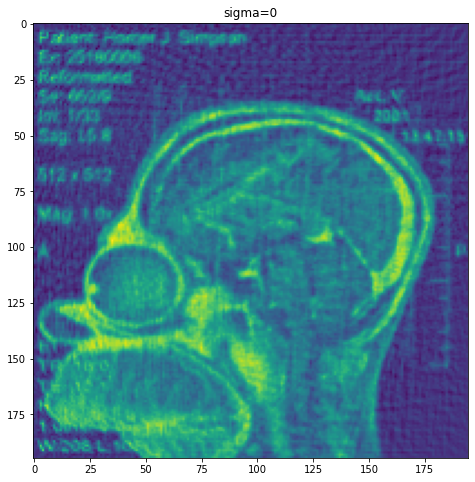

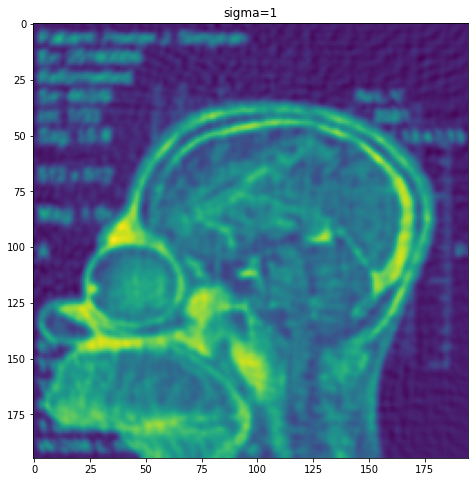

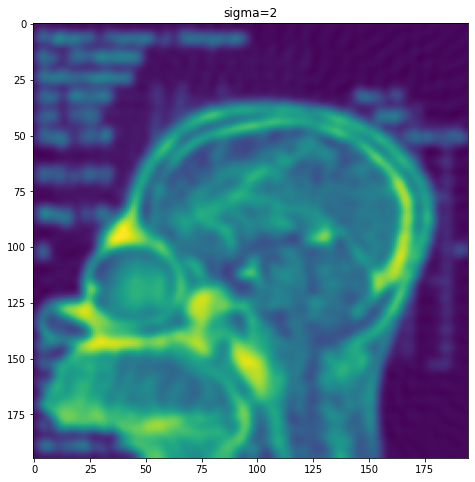

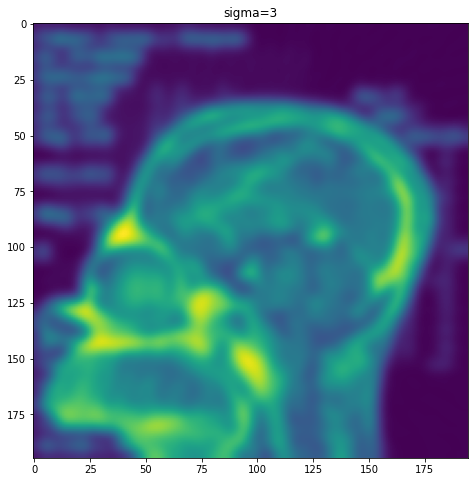

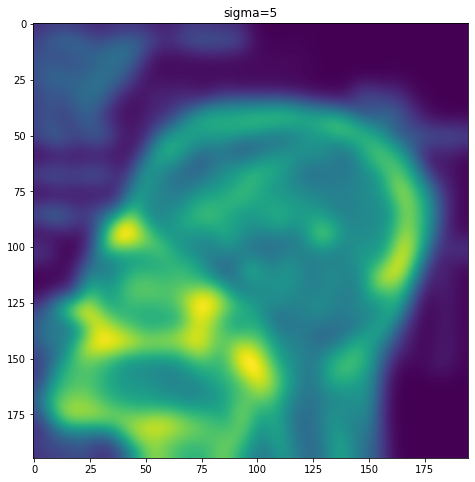

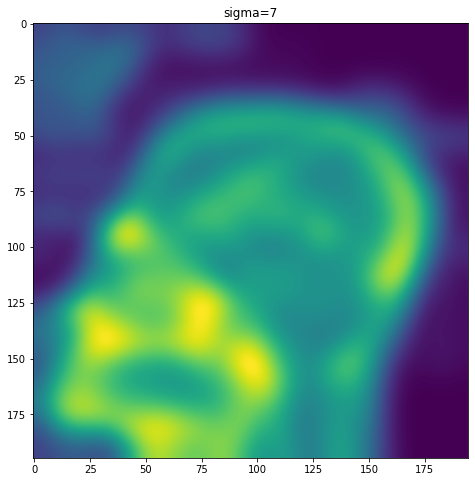

In [99]:
###########################
#COPIED FROM THE CELL ABOVE
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")
M=195
Np=275

#select 64 projections
idx = np.linspace(0, 179, num=64, endpoint=False, dtype=int)
alphas = alphas[idx] 

pixel_idx = np.repeat([np.ones(Np)], 64, axis=0) * np.array([idx]).transpose() * Np
pixel_idx = pixel_idx.flatten() + np.repeat([np.arange(Np)], 64, axis=0).flatten()
pixel_idx = np.array(pixel_idx, dtype=int)
y = y[pixel_idx]


#compute the image for tau=0
X = construct_X(M, alphas, Np)
beta = sparse.linalg.lsqr(X, y, atol=1e-5, btol=1e-5)[0]
beta = np.reshape(beta, (M,M))
###############################

for s in [0,1,2,3,5,7]:
    beta_filtered = gaussian_filter(beta, sigma=s)
    plt.figure(s, figsize=(8,8))
    plt.title("sigma="+str(s))
    plt.imshow(beta_filtered)

Of course, such evaluations are very subjective, but we think that the results from the gaussian filter is not better but even worse than those from the ridge regression method.

## 4 Automatic feature selection for regularization
### 4.1 Implement Orthogonal Matching Pursuit

In [4]:
def omp_regression(X, y, T):
    N, D = np.shape(X)
    X0 = X.copy()
    
    #Initial values
    A = np.array([])
    B = np.arange(D)
    r = y
    
    #initialize output
    betas = np.zeros((D,T))
    
    T = np.arange(0,T)
    for t in T:
        #determine index with maximum correlation in B
        corr = np.abs(np.dot(X.T, r))
        corr = corr
        j_B = np.where(corr==np.max(corr))[0][0]
        j  = B[j_B]
        
        #update active and passive set and the active matrix
        A = np.append(A, j)
        B = B[B!=j]
        X = X0[:,B]
        
        #solve least squares problem for the remaining columns
        beta = np.linalg.lstsq(X, y)[0]
        betas[B,t] = beta
    
    return betas      

In [5]:
#short test
X = np.array([[1,10,3,40,9],[3,4,5,6,7]])
y = np.array([1,2])
sol = omp_regression(X, y, 5)
print(sol)

[[ 0.14995314  0.19662921  0.25        0.7         0.        ]
 [-0.09044049 -0.00561798  0.          0.          0.        ]
 [ 0.20524836  0.28651685  0.25        0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.12652296  0.          0.          0.          0.        ]]


<ipython-input-4-ebb7e2af1b3d>:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta = np.linalg.lstsq(X, y)[0]
